In [324]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [325]:
class Node:
    """
    A Node in a Decision Tree.

    Parameters:
    - feature (int): The index of the feature used for splitting.
    - threshold (float): The threshold value for splitting.
    - left (Node): The left child node.
    - right (Node): The right child node.
    - value (int, optional): The class label for a leaf node.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        """Check if the node is a leaf node."""
        return self.value is not None

In [326]:
class DecisionTree:
    """
    Decision Tree Classifier implementing the C4.5 algorithm.

    Parameters:
    - min_samples_split (int): The minimum number of samples required to split a node.
    - max_depth (int): The maximum depth of the tree.
    """
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def _entropy(y):
        """Calculate the entropy of a dataset."""
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _gain_ratio(self, y, X_column, split_thresh):
        """
        Calculate the Gain Ratio for a given split threshold.

        Parameters:
        - y (NumPy Array): The target values.
        - X_column (NumPy Array): A column from the feature matrix.
        - split_thresh (float): The threshold to split at.
        """
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = X_column < split_thresh, X_column >= split_thresh
        n, n_left, n_right = len(y), np.sum(left_idxs), np.sum(right_idxs)

        if n_left == 0 or n_right == 0:
            return 0

        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Calculate Information Gain
        info_gain = parent_entropy - child_entropy

        # Calculate Split Info
        split_info = -((n_left / n) * np.log2(n_left / n) + (n_right / n) * np.log2(n_right / n))

        # Gain Ratio
        return info_gain / split_info if split_info != 0 else 0

    def _best_split(self, X, y):
        """
        Find the best split for a node.

        Parameters:
        - X (NumPy Array): The feature matrix.
        - y (NumPy Array): The target values.
        """
        best_gain = -1
        split_idx, split_thresh = None, None
        n_features = X.shape[1]
        for idx in range(n_features):
            X_column = X[:, idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._gain_ratio(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.

        Parameters:
        - X (NumPy Array): The feature matrix.
        - y (NumPy Array): The target values.
        - depth (int): The current depth of the tree.
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth 
                or n_labels == 1 
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        split_idx, split_thresh = self._best_split(X, y)
        left_idxs, right_idxs = X[:, split_idx] < split_thresh, X[:, split_idx] >= split_thresh
        left = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(split_idx, split_thresh, left, right)

    @staticmethod
    def _most_common_label(y):
        """
        Find the most common label in the dataset.

        Parameters:
        - y (NumPy Array): The target values.
        """
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    def fit(self, X, y):
        """
        Fit the Decision Tree Classifier to the data.

        Parameters:
        - X (NumPy Array): The feature matrix.
        - y (NumPy Array): The target values.
        """
        self.root = self._build_tree(X, y)

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        - X (NumPy Array): The feature matrix.
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Traverse the tree to find the class label for a sample.

        Parameters:
        - x (NumPy Array): A single sample from the feature matrix.
        - node (Node): The current node in the tree.
        """
        if node.is_leaf_node():
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [327]:
def print_metrics(y_test, y_pred):
    """
    Evaluates and displays the performance metrics of a classifier.

    Parameters:
    y_test (NumPy Array): True labels for the test dataset.
    y_pred (NumPy Array): Predicted labels by the classifier for the test dataset.

    The function computes and displays the following:
    - Classification report including precision, recall, f1-score for each class.
    - Overall accuracy of the model.
    - AUC score representing the classifier's ability to distinguish between classes.
    - Confusion Matrix visualized as a heatmap.
    """
    # Evaluation Metrics
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 14})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    # Labels for the quadrants
    labels = [['TN:', 'FP:'], ['FN:', 'TP:']]

    # Add text annotations for the quadrant labels
    for i in range(2):
        for j in range(2):
            plt.text(j+.3 , i+.3 , labels[i][j], 
                    horizontalalignment='center', 
                    verticalalignment='top', 
                    fontsize=16, color='black' if cm[i, j] > cm.max() / 2 else 'white')
    plt.show()

def plot_node(node, x, y, delta_x=1.0, delta_y=0.1, level=0, ax=None):
    """
    Recursive function to plot a node and its children.
    
    Parameters:
    node: The current node.
    x, y: Coordinates of the current node.
    delta_x, delta_y: Horizontal and vertical distances between nodes.
    level: Current level in the tree.
    ax: Matplotlib axes object.
    """
    if ax is None:
        ax = plt.gca()
    
    box_props = dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
    
    if node.is_leaf_node():
        ax.text(x, y, f'Class: {node.value}', horizontalalignment='center', fontsize=8, bbox=box_props)
    else:
        ax.text(x, y, f'Feature {node.feature}\n< {node.threshold:.2f}', horizontalalignment='center', fontsize=8, bbox=box_props)
        
        # Left child
        new_x, new_y = x - delta_x/(2**level), y - delta_y
        ax.plot([x , new_x], [y, new_y], 'k-')  # Adjust the starting point slightly
        plot_node(node.left, new_x, new_y, delta_x, delta_y, level+1, ax)

        # Right child
        new_x, new_y = x + delta_x/(2**level), y - delta_y
        ax.plot([x , new_x], [y , new_y], 'k-')  # Adjust the starting point slightly
        plot_node(node.right, new_x, new_y, delta_x, delta_y, level+1, ax)

def visualize_tree(tree):
    """
    Visualize the decision tree.
    
    Parameters:
    tree: The decision tree object.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_node(tree.root, 0.5, 1, 1.0, 0.1, 0, ax=ax)
    plt.axis('off')
    
    return fig

In [328]:
# Load the data
data = pd.read_csv('creditcard.csv')

# Subsample the data such that 90& of the data is fradulent and 10% is non-fraudulent
fraudulent = data[data['Class'] == 1]
non_fraudulent = data[data['Class'] == 0]

# Randomly sample non-fraudulent transactions
non_fraudulent_sample = non_fraudulent.sample(n=len(fraudulent)*9, random_state=42)

# Combine the fraudulent and non-fraudulent samples
subsample = pd.concat([fraudulent, non_fraudulent_sample])

# Split the data into features and target
X = subsample.drop(['Class','Time'], axis=1)
y = subsample['Class'].values

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=42)

In [329]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((492, 29), (4428, 29), (492,), (4428,))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3972
           1       0.94      0.82      0.87       456

    accuracy                           0.98      4428
   macro avg       0.96      0.91      0.93      4428
weighted avg       0.98      0.98      0.97      4428

Accuracy Score: 0.975609756097561
AUC: 0.9058441988657445


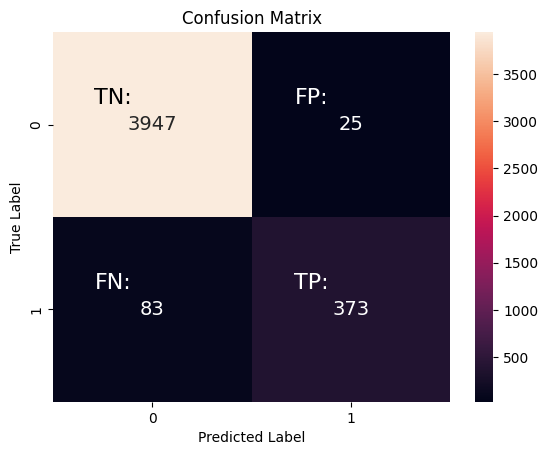

In [330]:
# Convert the dataframes to numpy arrays
X_train = X_train.values
X_test = X_test.values

# Initialize the Decision Tree Classifier
clf = DecisionTree(min_samples_split=10, max_depth=5)

# Train the Classifier
clf.fit(X_train, y_train)

# Make Predictions
y_pred = clf.predict(X_test)

# Print Metrics
print_metrics(y_test, y_pred)


C:\Users\Mr. Bisque\AppData\Local\Temp\ipykernel_7696\4224996767.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  tree.show()


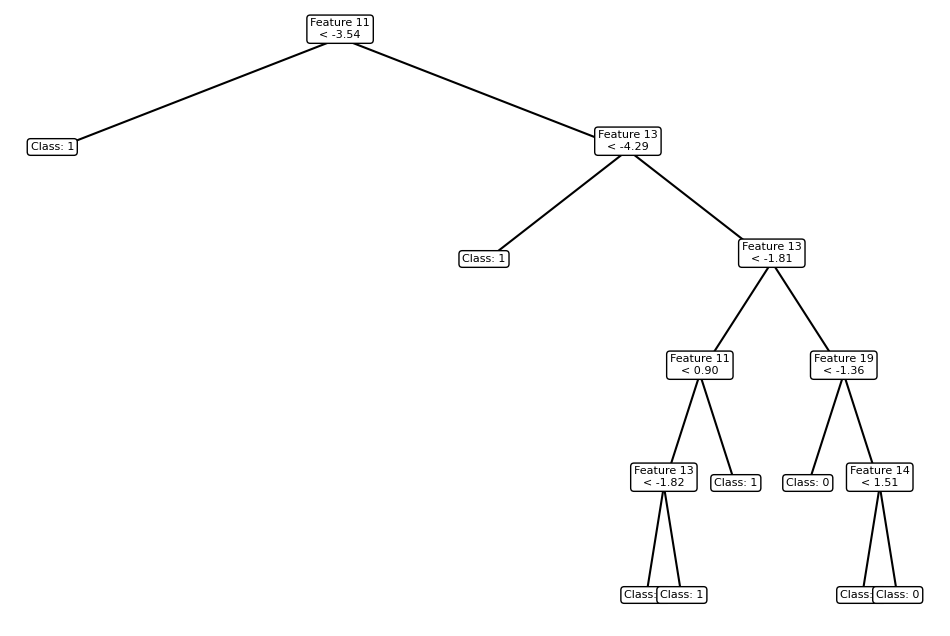

In [331]:
tree = visualize_tree(clf)
# Visualize the tree
tree.show()